In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

import math

import plotly.express as px

import pandas_datareader.data as web

from keras.callbacks import EarlyStopping

import keras
from keras.models import load_model
from keras.preprocessing.sequence import TimeseriesGenerator
#from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


## Introduction
Technical analysis is a trading discipline used to evaluate investments and identify trading opportunities in price trends and patterns from graphs.  Technical analysts believe past trading activity and price changes of a stock can be indicators of the security's future price movements.  The difference between 
technical analysis and fundamental analysis is that fundamental analysts focuses on a company's financials rather than historical price patterns or stock trends.  https://www.investopedia.com/terms/t/technicalanalysis.asp<br>
This notebook will demonstrate how to perform a basic technical analysis of stock prices using Python code.  I will provide analysis and insights of stock prices that can be obtained from historical stock price data and corresponding graphs.  In addition, this notebook will demonstrate how algorithmic trading can be used to predict stock prices and how technical indicators can used with LTSM models.<br>
I used the Pandas library DataReader to get the historical price stock data from Yahoo Finance API.  The library provides price and volume information regarding stocks. I will use mainly the Adjusted Closing Price ('Adj Close') from the datasets.<br>
In addition, I will use the Long Short Term Memory (LSTM ) and SARIMA models to forecast the next day stock price.  I will use the calculations from the technical indicators for forecasting.  In addition, I will use  metrics to measure the performance of the models at predicting stock prices.  
The data will consist of the following pharmaceutical companies that are developing  COVID-19 vaccines: 
* Pfizer (PFE),
* Johnson & Johnson (JNJ)
* Moderna (MRNA)
* Novavax (NVAX) 
* BioNTech SE (BNTX)
* MERCK & Co. (MRK)

## Historical Stock Data

### Multiple Stocks Data (multi_stocks)

In [2]:
from datetime import date
#today = date.today()
today = '04-30-2021'
def multiple_stock_data(ticker=None, start=None, end=None, plot=True, stock_value=None):
    
    try:
        #stock = pdr.get_data_yahoo(ticker,start,end)
        data = {}
        for stock in ticker:
            data = web.DataReader(stock,'yahoo',start,end)[stock_value]
        df_1 = pd.DataFrame(data)#.reset_index()
        if plot==True:
            df_1.plot(figsize=(12,8))
            label_font = {'weight':'bold','size':18}
            plt.title("Historical Adjusted Price Data",fontdict=label_font)
            plt.xlabel('Dates')
            plt.ylabel('Stocks Prices')
            plt.legend(bbox_to_anchor=(1.05,1),loc='upper left') 
        
        return df_1
     
    except Exception as e:
        print("Error occured:", e)
        #data = 'Incorrect Symbol'


Symbols,PFE,JNJ,NVAX,MRNA,AZN,BNTX
Date,,,,,,
2017-01-03,26.393257,103.436539,25.400000,NaN,23.433638,NaN
2017-01-04,26.625195,103.266876,26.200001,NaN,23.619688,NaN
2017-01-05,26.881132,104.347321,26.400000,NaN,24.262403,NaN
2017-01-06,26.777161,103.847282,27.400000,NaN,24.042524,NaN
2017-01-09,26.769159,103.829422,28.400000,NaN,24.127094,NaN
...,...,...,...,...,...,...
2021-05-03,39.441368,165.210007,195.119995,186.020004,53.700001,208.899994
2021-05-04,39.560196,167.770004,180.669998,173.589996,52.930000,176.880005
2021-05-05,39.580002,167.070007,171.740005,162.839996,53.650002,170.770004


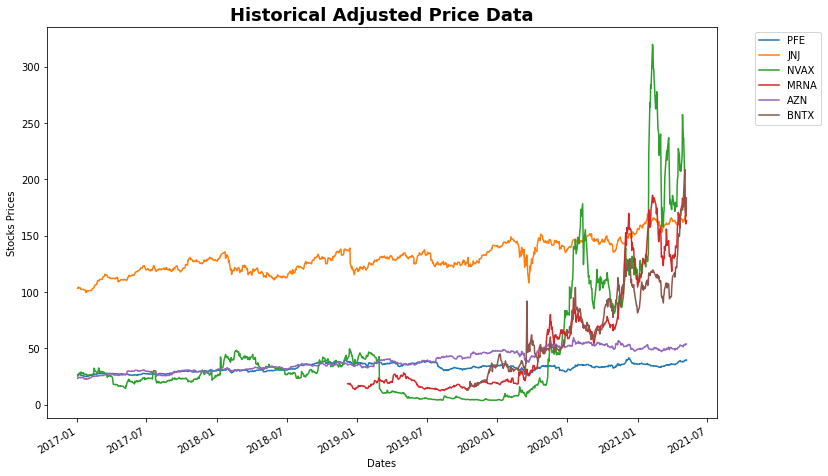

In [3]:
multi_stock_data = multiple_stock_data(ticker=[['PFE','JNJ','NVAX','MRNA','AZN','BNTX']], start='2017',end='today',plot=True, stock_value='Adj Close')
multi_stock_data

In [4]:
multi_stock_data.to_csv('multi_pharm_data')

In [5]:
#start='2017',end='today'
multi_stocks = pd.read_csv('multi_pharm_data', parse_dates=True, index_col='Date')

#### Multiple Stock Plot

In [6]:
def multi_plot(df, stock_value=None):
    #plt.figure(figsize=(12,8))
    df.plot(figsize=(12,8))
    label_font = {'weight':'bold','size':18}
    plt.xlabel('Date',fontdict=label_font)
    plt.ylabel(f'{stock_value} Price USD ($)',fontdict=label_font)
    plt.title(f'Historical {stock_value} Price',fontdict=label_font)            

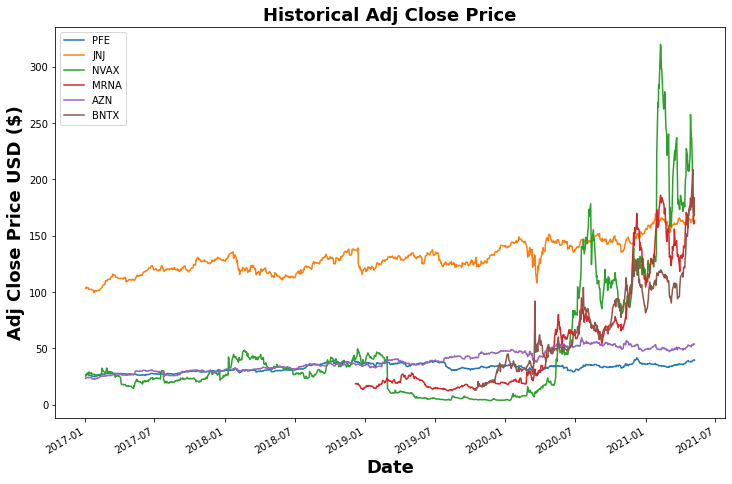

In [7]:
multi_plot(multi_stocks, stock_value='Adj Close')

In [8]:
multi_stocks.describe()

,PFE,JNJ,NVAX,MRNA,AZN,BNTX
count,1094.000000,1094.000000,1094.000000,608.000000,1094.000000,397.000000
mean,32.708488,130.827380,48.151965,55.319581,39.002276,70.957431
std,3.689415,14.563264,57.195907,49.371516,9.269537,38.264637
min,24.913631,99.793396,3.690000,12.260000,22.596422,12.750000
25%,29.869446,120.387264,14.072500,18.114999,30.903034,38.580002
50%,33.083639,128.574722,27.600000,26.095000,36.707993,66.120003
75%,35.891665,141.196846,44.000000,72.569998,47.813596,100.389999
max,41.691181,169.423508,319.929993,186.020004,59.466022,208.899994


### Single Stock Data (pfe_stock_data)

In [9]:
def single_stock_data(symbol, start,end=None,plot=True,stock_value='Adj Close'):
    
    try:
        
        df = web.DataReader(symbol,'yahoo', start, end)
        df_single = pd.DataFrame(df)
        print("Dataframe has {} rows and {} columns".format(df_single.shape[0],df_single.shape[1]))
        print()
        if plot==True:
            plt.figure(figsize=(12,8))
            plt.plot(df_single[stock_value])
            label_font = {'weight':'bold','size':18}
            plt.xlabel('Date',fontdict=label_font)
            plt.ylabel('Close Price USD ($)',fontdict=label_font)
            plt.title(f'Historical {stock_value} Price for {symbol}',fontdict=label_font)
            #plot = go.Scatter(x=df_single.index, y=df_single['Adj Close'])
            
        return df_single
        
    except Exception as e:
        #if inccorect symbol is inputted, error message displayed
        print("Error occured/Incorrect Symbol:", e)
        #data = 'Incorrect Symbol'


This is data for Pfizer.

Dataframe has 1094 rows and 6 columns



,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-01-03,31.309298,30.920303,31.024668,31.309298,23391844.0,26.393257
2017-01-04,31.641365,31.337761,31.432638,31.584440,22753963.0,26.625195
2017-01-05,31.963947,31.423149,31.660341,31.888046,21083584.0,26.881132
2017-01-06,31.973434,31.631880,31.935484,31.764706,18418228.0,26.777161
2017-01-09,31.944971,31.669828,31.717268,31.755219,21559886.0,26.769159
...,...,...,...,...,...,...
2021-05-03,39.840000,38.959999,39.040001,39.830002,46638600.0,39.441368
2021-05-04,40.169998,39.430000,40.000000,39.950001,52802200.0,39.560196
2021-05-05,41.090000,38.930000,40.180000,39.970001,54348400.0,39.580002


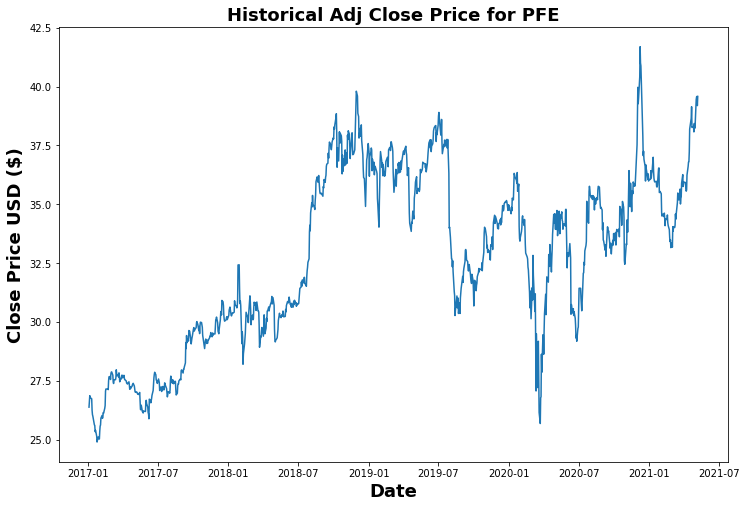

In [10]:
start='01-01-2017'
end='today'
pfe_stock = single_stock_data('PFE', start= start,end='today',plot=True,stock_value='Adj Close')
pfe_stock

In [11]:
pfe_stock.to_csv('pfe_stock')
pfe_stock_df = pd.read_csv('pfe_stock', parse_dates=True, index_col='Date')
#single_stock['Close']['2015-04-01':'2015-12-01'].plot()
pfe_stock_data = pfe_stock_df[['Close','Volume','Adj Close']]

In [12]:
pfe_stock_data.describe()

,Close,Volume,Adj Close
count,1094.000000,1.094000e+03,1094.000000
mean,35.641638,2.618101e+07,32.708488
std,3.271957,1.363625e+07,3.689415
min,27.030361,5.187683e+06,24.913631
25%,33.510108,1.830084e+07,29.869446
50%,34.924999,2.307854e+07,33.083639
75%,38.084350,2.966483e+07,35.891665
max,43.861481,2.301539e+08,41.691181


#### Single Stock Plot

In [13]:
def single_plot(df,stock_value=None, stock_symbol=None):
    df[stock_value].plot(figsize=(12,8))
    label_font = {'weight':'bold','size':18}
    plt.xlabel('Date',fontdict=label_font)
    plt.ylabel(f'{stock_value} Price USD ($)',fontdict=label_font)
    plt.title(f'{stock_symbol} {stock_value} History',fontdict=label_font)                

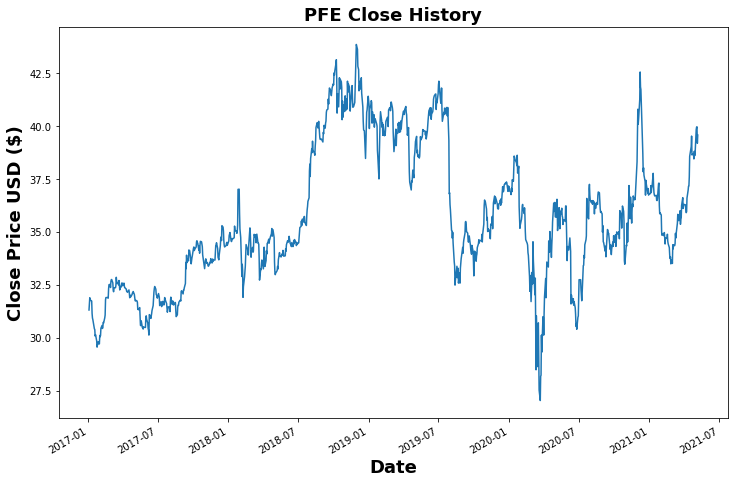

In [14]:
single_plot(pfe_stock_data, stock_value='Close', stock_symbol='PFE')

## Question 2: <br>Does the SARIMA algorithm perform better in predicting future stocks price with the Adj Close column or Technical Indicators ? 
This section focuses on using SARIMA models to predict future stock prices.  Autoregressive Integrated Moving Average, or ARIMA, is one of the most widely used forecasting methods for univariate time series data forecasting.  Although the method can handle data with a trend, it does not support time series with a seasonal component.  Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component. https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/

I will be working with univariate time series datasets.  I have created various functions which make it easy to work with different datasets and get corresponding predictions and plots.  I am starting with Pfizer then I will run the model with BVAX for a comparison.<br>
I created the function delta_data in order to add the calculations from the Techincal Indicators section to the stock dataset I obtained from Datareader.  I will be working with the columns Adj Close, MA_50 and Actual_Changes.

Adj Close:
<br>
The data covers the time period 3/15/17 to 4/1/21.  I applied the describe function to the 'Adj Close' column which provides a quick statistical overview of the data.  The average price of the stock was \\$33.20.  Regarding price range, the lowest price it reached was \\$25.95 and the highest was \\$42.10.  The std was 3.497 so the data points generally didn't deviate that far from each other.<br>
<br>

To make the predictions I will be using One-Step Ahead forecasting and Dynamic Forecasting. One Step Ahead static and dynamic forecasts are similar. The difference is with their estimation procedures. Dynamic forecasts use the value of the previous forecasted value of the dependent variable to compute the next one. Static forecast use the actual value for each subsequent forecast.

In [15]:
#start='01-01-2019',end='today',
#df_single = single_stock_data('PFE', start='01-01-2019',end='today',plot=True,stock_value='Adj Close')

## Sarima Model

In [16]:
import six
import joblib
import sys
sys.modules['sklearn.externals.six'] = six
sys.modules['sklearn.externals.joblib'] = joblib
import pmdarima as pm
from pmdarima import auto_arima

import statsmodels.api as sm

In [17]:
sarima_data = pfe_stock_data.copy()

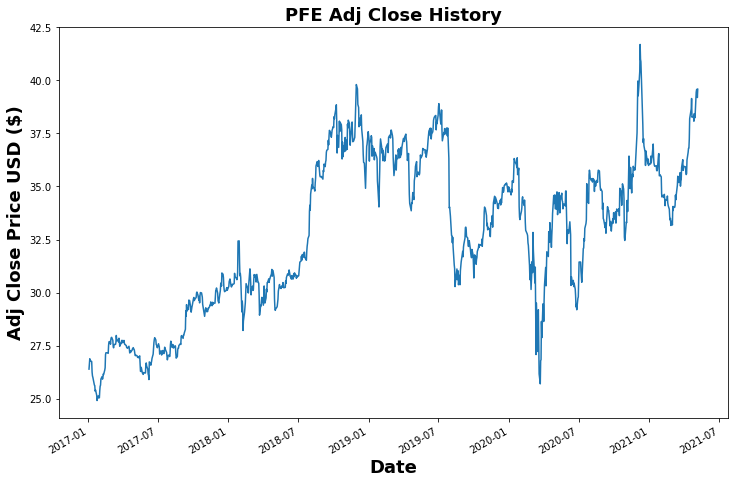

In [18]:
single_plot(pfe_stock_data, stock_value='Adj Close', stock_symbol='PFE')

#### Delta_data

In [19]:
def delta_data(data,col=None):
    data['Actual_Changes'] = data[col] - data[col].shift(1)
    data['Percent_Chg'] = data[col].pct_change(1)
    data['MA_50'] = data[col].rolling(50).mean()
    
    data = data.dropna()
    return data

In [20]:
sarima_df = delta_data(sarima_data,col='Adj Close')#delta_time_series(multi_stocks, col='Adj Close')
sarima_df

,Close,Volume,Adj Close,Actual_Changes,Percent_Chg,MA_50
Date,,,,,,
2017-03-15,32.855785,24279839.0,27.979099,0.331263,0.011982,26.540320
2017-03-16,32.666035,21816219.0,27.817513,-0.161587,-0.005775,26.568806
2017-03-17,32.561668,45736117.0,27.728630,-0.088882,-0.003195,26.590874
2017-03-20,32.618595,18435514.0,27.777109,0.048479,0.001748,26.608794
2017-03-21,32.495255,33083479.0,27.672075,-0.105034,-0.003781,26.626692
...,...,...,...,...,...,...
2021-05-03,39.830002,46638600.0,39.441368,1.168488,0.030530,35.873521
2021-05-04,39.950001,52802200.0,39.560196,0.118828,0.003013,35.986210
2021-05-05,39.970001,54348400.0,39.580002,0.019806,0.000501,36.106228


In [21]:
sarima_df

,Close,Volume,Adj Close,Actual_Changes,Percent_Chg,MA_50
Date,,,,,,
2017-03-15,32.855785,24279839.0,27.979099,0.331263,0.011982,26.540320
2017-03-16,32.666035,21816219.0,27.817513,-0.161587,-0.005775,26.568806
2017-03-17,32.561668,45736117.0,27.728630,-0.088882,-0.003195,26.590874
2017-03-20,32.618595,18435514.0,27.777109,0.048479,0.001748,26.608794
2017-03-21,32.495255,33083479.0,27.672075,-0.105034,-0.003781,26.626692
...,...,...,...,...,...,...
2021-05-03,39.830002,46638600.0,39.441368,1.168488,0.030530,35.873521
2021-05-04,39.950001,52802200.0,39.560196,0.118828,0.003013,35.986210
2021-05-05,39.970001,54348400.0,39.580002,0.019806,0.000501,36.106228


In [22]:
sarima_df['Adj Close'].describe()

count    1045.000000
mean       32.999090
std         3.510389
min        25.699234
25%        30.234791
50%        33.425819
75%        35.980194
max        41.691181
Name: Adj Close, dtype: float64

In [23]:
sarima_df.describe()

,Close,Volume,Adj Close,Actual_Changes,Percent_Chg,MA_50
count,1045.000000,1.045000e+03,1045.000000,1045.000000,1045.000000,1045.000000
mean,35.847197,2.613372e+07,32.999090,0.011418,0.000449,32.751853
std,3.196304,1.387090e+07,3.510389,0.478460,0.014556,3.305040
min,27.030361,5.187683e+06,25.699234,-2.487129,-0.077347,26.540320
25%,33.738140,1.809781e+07,30.234791,-0.180798,-0.005501,30.255774
50%,35.037952,2.272730e+07,33.425819,0.009903,0.000303,33.050429
75%,38.557877,2.955722e+07,35.980194,0.222145,0.006761,36.005223
max,43.861481,2.301539e+08,41.691181,2.602318,0.089607,37.742444


##### Train/Test Split

In [24]:
train = sarima_df[:int(0.8*(len(sarima_df)))]
test = sarima_df[int(0.8*(len(sarima_df))):]

In [25]:
len(sarima_df),len(train), len(test)

(1045, 836, 209)

In [26]:
test

,Close,Volume,Adj Close,Actual_Changes,Percent_Chg,MA_50
Date,,,,,,
2020-07-10,32.096775,24459019.0,30.820267,0.337082,0.011058,32.408542
2020-07-13,33.406071,56569129.0,32.077492,1.257225,0.040792,32.358044
2020-07-14,33.425049,32854129.0,32.095715,0.018223,0.000568,32.320900
2020-07-15,33.889942,26294454.0,32.542118,0.446404,0.013909,32.293044
2020-07-16,33.776093,18421812.0,32.432796,-0.109322,-0.003359,32.246946
...,...,...,...,...,...,...
2021-05-03,39.830002,46638600.0,39.441368,1.168488,0.030530,35.873521
2021-05-04,39.950001,52802200.0,39.560196,0.118828,0.003013,35.986210
2021-05-05,39.970001,54348400.0,39.580002,0.019806,0.000501,36.106228


In [27]:
test['Adj Close'].describe()

count    209.000000
mean      35.380223
std        1.896044
min       30.820267
25%       34.000900
50%       35.279617
75%       36.068356
max       41.691181
Name: Adj Close, dtype: float64

##### Auto ARIMA Model Function

In [28]:
def arima_model(df):
    """
    df- dataframe
    function is a gridsearch to get optimal p,d,qs and lowest AIC for the model.
    q-is moving average
    """
    autoarima_model = auto_arima(df, start_p = 0, start_q = 0, #start_q = 0
                              test='adf',             # use adftest to find optimal 'd'
                              max_p = 3, max_q = 3,   # maximum p and q
                              m = 12,                  #frequency of series 
                              d = None,               # let model determine 'd', was 1
                              seasonal = True, 
                              start_P=0, D=1, trace = False, #start  #trace= True
                              error_action ='ignore',   # we don't want to know if an order does not work 
                              suppress_warnings = True,  # we don't want convergence warnings 
                              stepwise = True)           # set to stepwise  
    
    #print('\n')
    #display(autoarima_model.summary())
    
    return autoarima_model


In [29]:
adj_close = 'Adj Close'
ma_50 = 'MA_50'
actual_changes = 'Actual_Changes'

#### Pfizer / Adj Close

##### Code to get PDQs and AIC

In [ ]:
#for loop iterates to get the PDQs, Seasonal PDQs and AICS for each column
arima_list = [['hist', 'pdq','seasonal_pdq','aic']] 
for col in sarima_df.columns:
  zip_test_2 = arima_model(sarima_df[col])
  arima_list.append([col,zip_test_2.order, zip_test_2.seasonal_order, zip_test_2.aic()])
#result   
output_df = pd.DataFrame(arima_list[1:],columns=arima_list[0]) 
output_df  

In [ ]:
#function that fit SARIMA model
def fit_ARIMA(df, order=None, seasonal_order=None):
    """
    forecasting statsmodel SARIMAX model
    """
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df, 
                                        order=order, 
                                        seasonal_order=seasonal_order, 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

    # Fit the model and print results
    output = ARIMA_MODEL.fit()

    #display / no tables 1
    display(output.summary())
    
    print('\n')
    print('MODEL DIAGNOSTICS')
    
    output.plot_diagnostics(figsize=(15, 18));
    plt.show()
    
    return output

#### One Step Ahead Forecasting

In [ ]:
#code for one-step ahead forecasting
hist_type = adj_close #hist_type = 'Adj Close'
hist_params= output_df[output_df['hist']==hist_type]
hist_params.pdq.values[0]
hist_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(sarima_df[hist_type],order=hist_params.pdq.values[0], seasonal_order= hist_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 

pred = output_sarima.get_prediction(start=pd.to_datetime('2020-06-05'), dynamic=False)
pred_conf = pred.conf_int()

##### One-Step Ahead Plot

This plot pertains to the One Step Ahead Forecasting.  The green line in the plot represents the prediction. The green line has a shaded green area around it called the confidence intervals.  What are confidence intervals?  Confidence intervals are a range in values.  The default alpha of .05 returns a 95% confidence interval.  A 95% confidence interval represents that if we take an infinite number of samples from the population, calculate the interval each time, then in 95% of those intervals, the interval will contain the true population mean.   This represents the model’s uncertainty in the forecast.  <br> 
In this case, the confidence interval width is set at 95%, meaning we expect that this range will contain the actual value 95% of the time. Any time a prediction is made we must include a confidence interval.<br>
The orange line represents the test set. We can tell from the plot that the model is performing pretty well because the green line follows the orange line closely.  When the RMSE metric is applied to the model to evaluate its performence we see that the model's performance was 0.54.  The average price of the stock was \\$33.22.  This means that in making the predictions the model was off 0.54.  The model did a pretty good job at forecasting the prediction.<br>

In [ ]:
def one_step(train, test, one_adj_c, pred, pred_conf):
    plt.figure(figsize=(12,6))
    # Plot observed values

    #ax = train['Adj Close']['2019':].plot(label='observed')
    ax = train[one_adj_c ]['2019':].plot(label='observed')#
    #test['Adj Close']['2019':].plot()#label='Test'
    test[one_adj_c]['2019':].plot()#label='Test'
    # Plot predicted values
    pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

    # Plot the range for confidence intervals
    ax.fill_between(pred_conf.index,
                    pred_conf.iloc[:, 0],
                    pred_conf.iloc[:, 1], color='g', alpha=0.5)

    # Set axes labels
    ax.set_xlabel('Date')
    ax.set_ylabel('Sale Price')
    plt.legend()

In [ ]:
one_step_forecast = one_step(train=train, test=test, one_adj_c= adj_close, pred=pred,pred_conf=pred_conf)

##### Metrics Function for One-Step Ahead

In [ ]:
def metric_func_one(pred, test, sarima_col):
    # Get the real and predicted values
    forecast = pred.predicted_mean
    actual =test[sarima_col] #actual =test['Adj Close']['1996':], was RMSE 0.54

    #root mean square error
    mse = ((forecast - actual) ** 2).mean()
    print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
    #np.sqrt(np.mean((predictions-targets)**2))
    rmse = np.sqrt(np.mean((forecast - actual) ** 2))
    print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))
    
    return mse, rmse

In [ ]:
one_mse_adj, one_rmse_adj = metric_func_one(pred, test, sarima_col= adj_close)

In [ ]:
one_rmse_adj

#### Dynamic Forecasting 
The average price for 'Adj Close' is \\$33.215.  The average price for the test set is \\$35.01.  The green line is the prediction.  It looks like the model predicted the price to be around \\$34.00.  It looks like the model did a pretty good job in making predictions because the predictions are close to the average price.  The below metric function shows that the model's performance was \\$2.71, so for the predictions the model was off \\$2.71.   

In [ ]:
#dynamic forecasting
history_type = adj_close #history_type = 'Adj Close'
zip_params = output_df[output_df['hist']==history_type]
zip_params.pdq.values[0]
zip_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(sarima_df[history_type],order=zip_params.pdq.values[0] ,seasonal_order= zip_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output_sarima.get_prediction(start=pd.to_datetime('2020-06-05'), dynamic=True,full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

##### Dynamic Forecasting Plot


In [ ]:
def prediction_vis(pred_dynamic,pred_dynamic_conf,train, one_adj_c,test):
    plt.figure(figsize=(12,6))
    # Plot observed values

    #ax = train['Adj Close']['2019':].plot(label='observed')
    ax = train[one_adj_c]['2019':].plot(label='observed')#
    #test['Adj Close']['2019':].plot()#label='Test'
    test[one_adj_c]['2019':].plot()#label='Test'
    # Plot predicted values
    pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecast', alpha=0.9)

    # Plot the range for confidence intervals
    ax.fill_between(pred_dynamic_conf.index,
                    pred_dynamic_conf.iloc[:, 0],
                    pred_dynamic_conf.iloc[:, 1], color='g', alpha=0.5)

    # Set axes labels
    ax.set_xlabel('Date')
    ax.set_ylabel('Sale Price')
    plt.legend()

In [ ]:
prediction_visual_1 = prediction_vis(pred_dynamic=pred_dynamic,pred_dynamic_conf=pred_dynamic_conf,
                                     train=train,test=test, one_adj_c= adj_close)#'Adj Close'

##### Metrics Function for Dynamic Forecasting

In [ ]:
def metric_func_dynamic(pred_dynamic, test, sarima_col):
    # Get the real and predicted values
    forecast = pred_dynamic.predicted_mean
    actual = test[sarima_col]#['1996':] #history_type

    # Compute the mean square error
    mse = ((forecast - actual) ** 2).mean()
    print('The Mean Squared Error of the forecast is {}'.format(round(mse, 2)))
    #np.sqrt(np.mean((predictions-targets)**2))
    rmse = np.sqrt(np.mean((forecast - actual) ** 2))
    print('The Root Mean Squared Error of the forecast is {}'.format(round(rmse, 2)))
    
    return mse, rmse
    

In [ ]:
dyn_mse_adj,dyn_rmse_adj,  = metric_func_dynamic(pred_dynamic, test, sarima_col =adj_close)

In [ ]:
dyn_rmse_adj

#### Pfizer / One-Step / MA_50
The model performed well in making predictions. The green line follows closely the orange line.  I applied the RMSE to the model and the result was 0.02.

In [ ]:
hist_type = ma_50 
hist_params= output_df[output_df['hist']==hist_type]
hist_params.pdq.values[0]
hist_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(sarima_df[hist_type],order=hist_params.pdq.values[0], seasonal_order= hist_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 

pred = output_sarima.get_prediction(start=pd.to_datetime('2020-06-05'), dynamic=False)
pred_conf = pred.conf_int()

In [ ]:
one_step_forecast_1 = one_step(train=train, test=test, one_adj_c= ma_50, pred=pred,pred_conf=pred_conf)

In [ ]:
metric_func_1 = metric_func_one(pred, test, ma_50)

In [ ]:
test['MA_50']

#### Pfizer/ Dynamic / MA_50
The model doesn't appear to have performed as well with this column. The model's green line fluctuates betwee 36 and 33 but after 12/20 is predicting 34.  However, when evaluating the model's performane the predictions were off 1.72 so it still performed pretty well. 

In [ ]:
history_type = ma_50 #history_type = 'Adj Close'
zip_params = output_df[output_df['hist']==history_type]
zip_params.pdq.values[0]
zip_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(sarima_df[history_type],order=zip_params.pdq.values[0] ,seasonal_order= zip_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output_sarima.get_prediction(start=pd.to_datetime('2020-06-05'), dynamic=True,full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

In [ ]:
prediction_visual_1 = prediction_vis(pred_dynamic=pred_dynamic,pred_dynamic_conf=pred_dynamic_conf,
                                     train=train,test=test,one_adj_c= 'MA_50')

In [ ]:
metric_func_dynamic(pred_dynamic, test, ma_50)

#### Pfizer / Actual_Changes
The model's predictions are centered around 0. The confidence intervals indicate there's a quite a range of values in the test set.  The model's performance was 0.54.


In [ ]:
hist_type = actual_changes  #hist_type = 'Adj Close'
hist_params= output_df[output_df['hist']==hist_type]
hist_params.pdq.values[0]
hist_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(sarima_df[hist_type],order=hist_params.pdq.values[0], seasonal_order= hist_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 

pred = output_sarima.get_prediction(start=pd.to_datetime('2020-06-05'), dynamic=False)
pred_conf = pred.conf_int()

In [ ]:
one_step_forecast_2 = one_step(train=train, test=test, one_adj_c= actual_changes, pred=pred,pred_conf=pred_conf)

In [ ]:
metric_func_2 = metric_func_one(pred, test, actual_changes)

Regarding Dynamic Forecasting, the model's predictions were centered around 0. The confidence intervals have a large rang in possible values. 

In [ ]:
history_type = actual_changes  #history_type = 'Adj Close'
zip_params = output_df[output_df['hist']==history_type]
zip_params.pdq.values[0]
zip_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(sarima_df[history_type],order=zip_params.pdq.values[0] ,seasonal_order= zip_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output_sarima.get_prediction(start=pd.to_datetime('2020-06-05'), dynamic=True,full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

In [ ]:
prediction_visual_3 = prediction_vis(pred_dynamic=pred_dynamic,pred_dynamic_conf=pred_dynamic_conf,
                                     train=train,test=test,one_adj_c= actual_changes)


In [ ]:
metric_func_dynamic(pred_dynamic, test, actual_changes)

#### BNTX 

In [ ]:
start='01-01-2017'
end='today'
bntx_stock = single_stock_data('BNTX', start= start,end='today',plot=True,stock_value='Adj Close')
bntx_stock

In [ ]:
bntx_stock['Adj Close'].describe()

In [ ]:
bntx_df = delta_data(bntx_stock,col='Adj Close')
train = bntx_df[:int(0.8*(len(bntx_df)))]
test = bntx_df[int(0.8*(len(bntx_df))):]

In [ ]:
train

In [ ]:
test

#### BNTX / Adj Close
##### BNTX / One-Step Ahead
The green line follows the orange line closely.  The model's performance was 3.91. 

In [ ]:
hist_type = adj_close #hist_type = 'Adj Close'
hist_params= output_df[output_df['hist']==hist_type]
hist_params.pdq.values[0]
hist_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(bntx_df[hist_type],order=hist_params.pdq.values[0], seasonal_order= hist_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 

pred = output_sarima.get_prediction(start=pd.to_datetime('2021-01-05'), dynamic=False)
pred_conf = pred.conf_int()

In [ ]:
#blue actual
#green line is forecast
#orange-test 
#green shade confidence interval
one_step_forecast_4 = one_step(train=train, test=test, one_adj_c= adj_close, pred=pred,pred_conf=pred_conf)

In [ ]:

metric_func_one(pred, test, sarima_col= adj_close)

In [ ]:
history_type = adj_close #history_type = 'Adj Close'
zip_params = output_df[output_df['hist']==history_type]
zip_params.pdq.values[0]
zip_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(bntx_df[history_type],order=zip_params.pdq.values[0] ,seasonal_order= zip_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output_sarima.get_prediction(start=pd.to_datetime('2021-01-05'), dynamic=True,full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

In [ ]:
#gren line is forcast
#green shades gives more range for forecast
#one_adj_c = 'Adj Close'
# prediction_visual_3 = prediction_vis(pred_dynamic,pred_dynamic_conf,train, one_adj_c,test)
# prediction_visual_3
prediction_visual_4 = prediction_vis(pred_dynamic=pred_dynamic,pred_dynamic_conf=pred_dynamic_conf,
                                     train=train,test=test,one_adj_c= adj_close)


In [ ]:
metric_func_dynamic(pred_dynamic, test, adj_close)

#### BNTX / MA_50

In [ ]:
bntx_stock['MA_50'].describe()

In [ ]:
#check
hist_type = ma_50  #hist_type = 'Adj Close'
hist_params= output_df[output_df['hist']==hist_type]
hist_params.pdq.values[0]
hist_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(sarima_df[hist_type],order=hist_params.pdq.values[0], seasonal_order= hist_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 

pred = output_sarima.get_prediction(start=pd.to_datetime('2021-01-05'), dynamic=False)
pred_conf = pred.conf_int()

In [ ]:
one_step_forecast_5 = one_step(train=train, test=test, one_adj_c= 'MA_50', pred=pred,pred_conf=pred_conf)#'MA_50'


In [ ]:
metric_func_one(pred, test, ma_50)

In [ ]:
history_type = ma_50 #history_type = 'Adj Close'
zip_params = output_df[output_df['hist']==history_type]
zip_params.pdq.values[0]
zip_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(bntx_df[history_type],order=zip_params.pdq.values[0] ,seasonal_order= zip_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output_sarima.get_prediction(start=pd.to_datetime('2021-01-05'), dynamic=True,full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

In [ ]:
prediction_visual_5 = prediction_vis(pred_dynamic=pred_dynamic,pred_dynamic_conf=pred_dynamic_conf,
                                     train=train,test=test,one_adj_c= ma_50)


In [ ]:
metric_func_dynamic(pred_dynamic, test, ma_50)

#### BNTX / actual_changes

In [ ]:
hist_type = actual_changes  
hist_params= output_df[output_df['hist']==hist_type]
hist_params.pdq.values[0]
hist_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(sarima_df[hist_type],order=hist_params.pdq.values[0], seasonal_order= hist_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 

pred = output_sarima.get_prediction(start=pd.to_datetime('2021-01-05'), dynamic=False)
pred_conf = pred.conf_int()

In [ ]:
one_step_forecast_5 = one_step(train=train, test=test, one_adj_c= actual_changes, pred=pred,pred_conf=pred_conf)#'MA_50'


In [ ]:
metric_func_one(pred, test, actual_changes)

In [ ]:
history_type = actual_changes #history_type = 'Adj Close'
zip_params = output_df[output_df['hist']==history_type]
zip_params.pdq.values[0]
zip_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(bntx_df[history_type],order=zip_params.pdq.values[0] ,seasonal_order= zip_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output_sarima.get_prediction(start=pd.to_datetime('2021-01-05'), dynamic=True,full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

In [ ]:
prediction_visual_5 = prediction_vis(pred_dynamic=pred_dynamic,pred_dynamic_conf=pred_dynamic_conf,
                                     train=train,test=test,one_adj_c= actual_changes)


In [ ]:
metric_func_dynamic(pred_dynamic, test, actual_changes)